In [2]:
import hashlib
import os
import pickle
from urllib.request import urlretrieve

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile

print('All modules imported.')

All modules imported.


In [4]:
def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        urlretrieve(url, file)
        print('Download Finished')

# Download the training and test dataset.
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_train.zip', 'notMNIST_train.zip')
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_test.zip', 'notMNIST_test.zip')

# Make sure the files aren't corrupted
assert hashlib.md5(open('notMNIST_train.zip', 'rb').read()).hexdigest() == 'c8673b3f28f489e9cdf3a3d74e2ac8fa',\
        'notMNIST_train.zip file is corrupted.  Remove the file and try again.'
assert hashlib.md5(open('notMNIST_test.zip', 'rb').read()).hexdigest() == '5d3c7e653e63471c88df796156a9dfa9',\
        'notMNIST_test.zip file is corrupted.  Remove the file and try again.'

# Wait until you see that all files have been downloaded.
print('All files downloaded.')

Download Finished
Download Finished
All files downloaded.


In [5]:
def uncompress_features_labels(file):
    """
    Uncompress features and labels from a zip file
    :param file: The zip file to extract the data from
    """
    features = []
    labels = []

    with ZipFile(file) as zipf:
        # Progress Bar
        filenames_pbar = tqdm(zipf.namelist(), unit='files')
        
        # Get features and labels from all files
        for filename in filenames_pbar:
            # Check if the file is a directory
            if not filename.endswith('/'):
                with zipf.open(filename) as image_file:
                    image = Image.open(image_file)
                    image.load()
                    # Load image data as 1 dimensional array
                    # We're using float32 to save on memory space
                    feature = np.array(image, dtype=np.float32).flatten()

                # Get the the letter from the filename.  This is the letter of the image.
                label = os.path.split(filename)[1][0]

                features.append(feature)
                labels.append(label)
    return np.array(features), np.array(labels)

# Get the features and labels from the zip files
train_features, train_labels = uncompress_features_labels('notMNIST_train.zip')
test_features, test_labels = uncompress_features_labels('notMNIST_test.zip')

# Limit the amount of data to work with a docker container
docker_size_limit = 150000
train_features, train_labels = resample(train_features, train_labels, n_samples=docker_size_limit)

# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False

# Wait until you see that all features and labels have been uncompressed.
print('All features and labels uncompressed.')

100%|██████████| 10001/10001 [00:02<00:00, 4292.92files/s]


All features and labels uncompressed.


In [8]:
# Problem 1 - Implement Min-Max scaling for grayscale image data
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # TODO: Implement Min-Max scaling for grayscale image data
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )


### DON'T MODIFY ANYTHING BELOW ###
# Test Cases
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 255])),
    [0.1, 0.103137254902, 0.106274509804, 0.109411764706, 0.112549019608, 0.11568627451, 0.118823529412, 0.121960784314,
     0.125098039216, 0.128235294118, 0.13137254902, 0.9],
    decimal=3)
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 10, 20, 30, 40, 233, 244, 254,255])),
    [0.1, 0.103137254902, 0.13137254902, 0.162745098039, 0.194117647059, 0.225490196078, 0.830980392157, 0.865490196078,
     0.896862745098, 0.9])

if not is_features_normal:
    print('Processing to Normalise!')
    train_features = normalize_grayscale(train_features)
    test_features = normalize_grayscale(test_features)
    is_features_normal = True

print('Tests Passed!')

Tests Passed!


In [9]:
if not is_labels_encod:
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(train_labels)
    train_labels = encoder.transform(train_labels)
    test_labels = encoder.transform(test_labels)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    train_labels = train_labels.astype(np.float32)
    test_labels = test_labels.astype(np.float32)
    is_labels_encod = True

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


In [10]:
assert is_features_normal, 'You skipped the step to normalize the features'
assert is_labels_encod, 'You skipped the step to One-Hot Encode the labels'

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


In [11]:
# Save the data for easy access
pickle_file = 'notMNIST.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('notMNIST.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


In [12]:
%matplotlib inline

# Load the modules
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sbs; sbs.set()

# Reload the data
pickle_file = 'notMNIST.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory


print('Data and modules loaded.')

Data and modules loaded.


In [15]:
features_count = 784
labels_count = 10

# TODO: Set the features and labels tensors
features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32) 

# TODO: Set the weights and biases tensors
weights = tf.Variable(tf.truncated_normal((features_count, labels_count)))
biases = tf.Variable(tf.zeros(labels_count))



### DON'T MODIFY ANYTHING BELOW ###

#Test Cases
from tensorflow.python.ops.variables import Variable

assert features._op.name.startswith('Placeholder'), 'features must be a placeholder'
assert labels._op.name.startswith('Placeholder'), 'labels must be a placeholder'
assert isinstance(weights, Variable), 'weights must be a TensorFlow variable'
assert isinstance(biases, Variable), 'biases must be a TensorFlow variable'

#Change _shape to .shape to supress warning
assert features.shape == None or (\
    features.shape.dims[0].value is None and\
    features.shape.dims[1].value in [None, 784]), 'The shape of features is incorrect'
assert labels.shape in [None, 10], 'The shape of labels is incorrect'
assert weights._variable.shape == (784, 10), 'The shape of weights is incorrect'
assert biases._variable.shape == (10), 'The shape of biases is incorrect'

assert features._dtype == tf.float32, 'features must be type float32'
assert labels._dtype == tf.float32, 'labels must be type float32'

# Feed dicts for training, validation, and test session
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

# Linear Function WX + b
logits = tf.matmul(features, weights) + biases

prediction = tf.nn.softmax(logits)

# Cross entropy
cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)

# Training loss
loss = tf.reduce_mean(cross_entropy)

# Create an operation that initializes all variables
init = tf.initialize_all_variables()

# Test Cases
with tf.Session() as session:
    session.run(init)
    session.run(loss, feed_dict=train_feed_dict)
    session.run(loss, feed_dict=valid_feed_dict)
    session.run(loss, feed_dict=test_feed_dict)
    biases_data = session.run(biases)

assert not np.count_nonzero(biases_data), 'biases must be zeros'

print('Tests Passed!')

Tests Passed!


In [20]:
# print prediction and labels
print('Labels',labels)
print('Prediction.',prediction)

# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print('Accuracy function created.')

Labels Tensor("Placeholder_3:0", dtype=float32)
Prediction. Tensor("Softmax_1:0", shape=(?, 10), dtype=float32)
Accuracy function created.


####################################
Running cross validation options one
####################################


Epoch  1/1: 100%|██████████| 72/72 [00:01<00:00, 67.70batches/s]


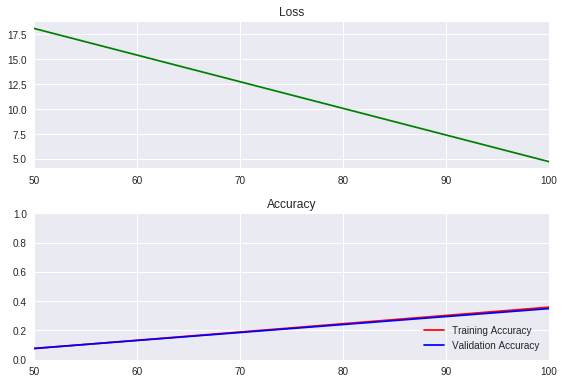

Validation accuracy at 0.43346667289733887


Epoch  1/1: 100%|██████████| 143/143 [00:01<00:00, 107.09batches/s]


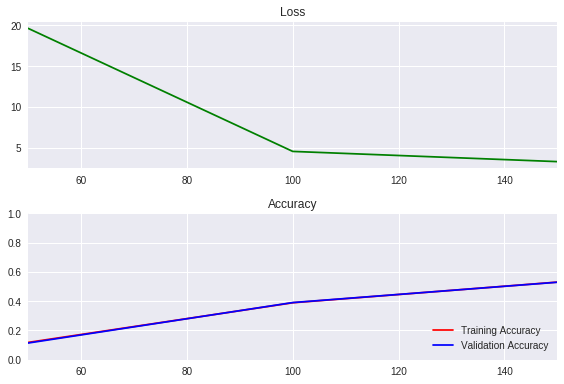

Validation accuracy at 0.5831999778747559


Epoch  1/1: 100%|██████████| 285/285 [00:02<00:00, 127.24batches/s]


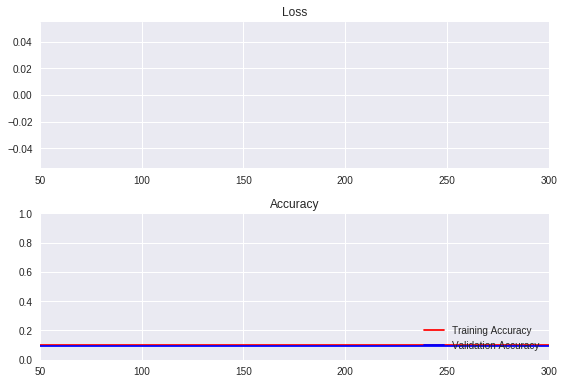

Validation accuracy at 0.09359999746084213


Epoch  1/1: 100%|██████████| 475/475 [00:03<00:00, 139.59batches/s]


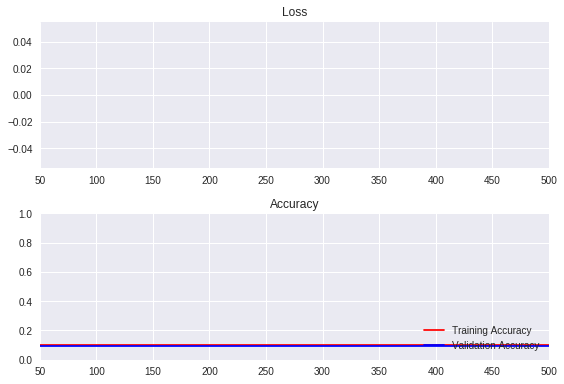

Validation accuracy at 0.09359999746084213


Epoch  1/1: 100%|██████████| 2850/2850 [00:17<00:00, 162.84batches/s]


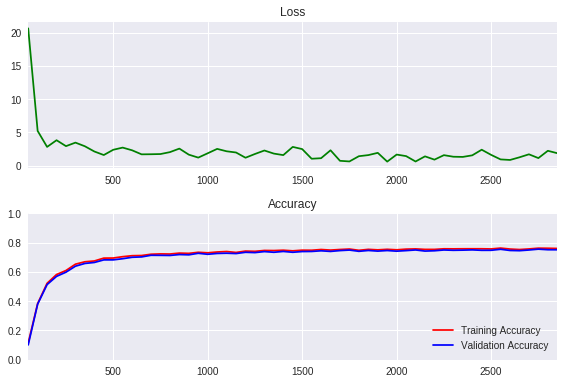

Validation accuracy at 0.7474666833877563
####################################
Running cross validation options two
####################################


Epoch  1/1: 100%|██████████| 1425/1425 [00:09<00:00, 153.16batches/s]


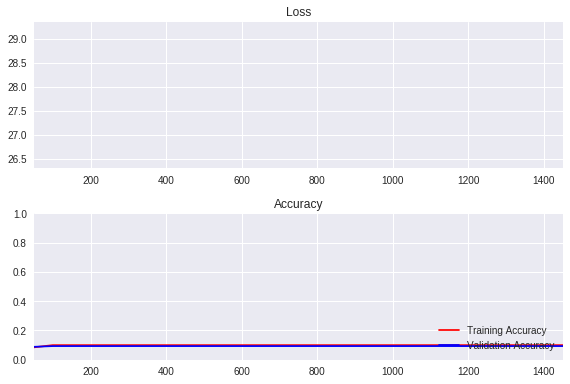

Validation accuracy at 0.09359999746084213


Epoch  1/1: 100%|██████████| 1425/1425 [00:09<00:00, 157.45batches/s]


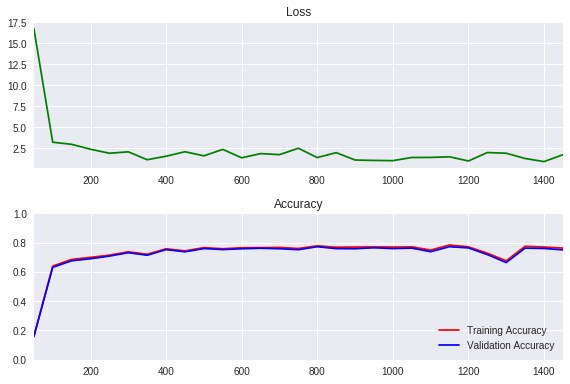

Validation accuracy at 0.7546666860580444


Epoch  1/1: 100%|██████████| 1425/1425 [00:09<00:00, 157.58batches/s]


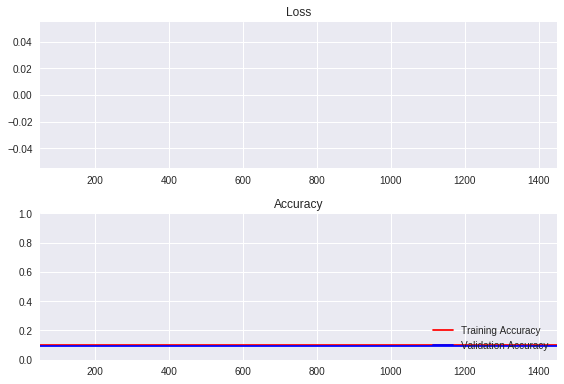

Validation accuracy at 0.09359999746084213


Epoch  1/1: 100%|██████████| 1425/1425 [00:09<00:00, 156.97batches/s]


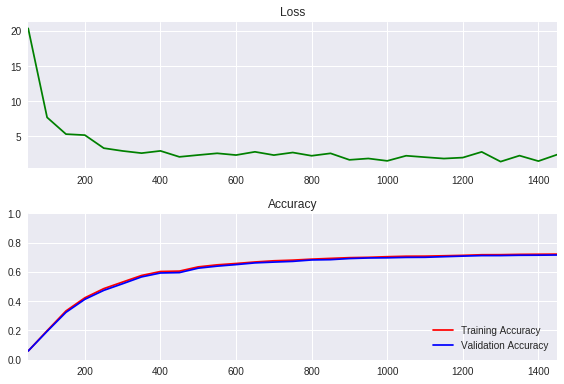

Validation accuracy at 0.718666672706604


Epoch  1/1: 100%|██████████| 1425/1425 [00:09<00:00, 156.35batches/s]


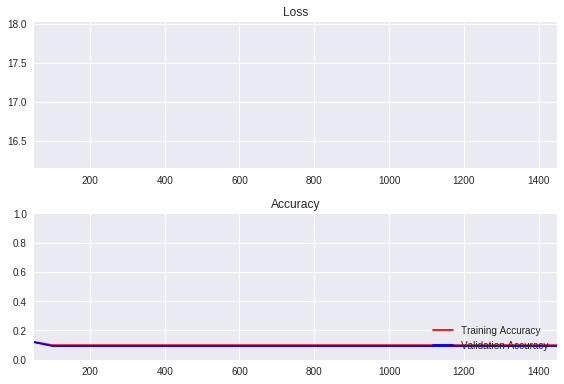

Validation accuracy at 0.09359999746084213
####################################
Running cross validation options three
####################################


Epoch  1/1: 100%|██████████| 1425/1425 [00:09<00:00, 157.46batches/s]


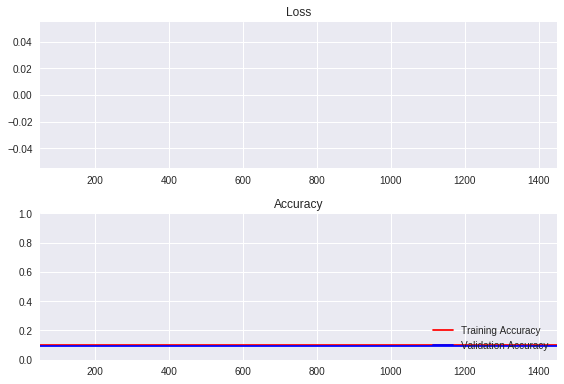

Validation accuracy at 0.09359999746084213


Epoch  2/2: 100%|██████████| 1425/1425 [00:08<00:00, 161.97batches/s]


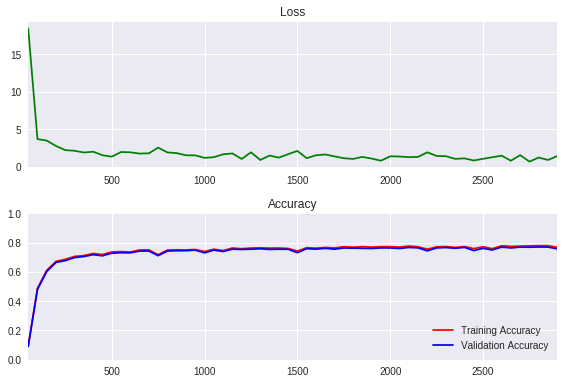

Validation accuracy at 0.7671999931335449


Epoch  3/3: 100%|██████████| 1425/1425 [00:08<00:00, 161.57batches/s]


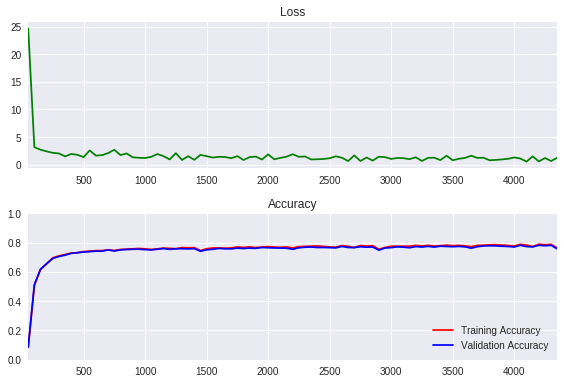

Validation accuracy at 0.7796000242233276


Epoch  4/4: 100%|██████████| 1425/1425 [00:08<00:00, 161.17batches/s]


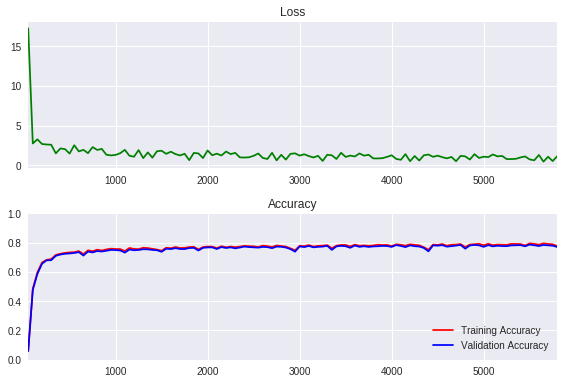

Validation accuracy at 0.7793333530426025


Epoch  5/5: 100%|██████████| 1425/1425 [00:08<00:00, 161.22batches/s]


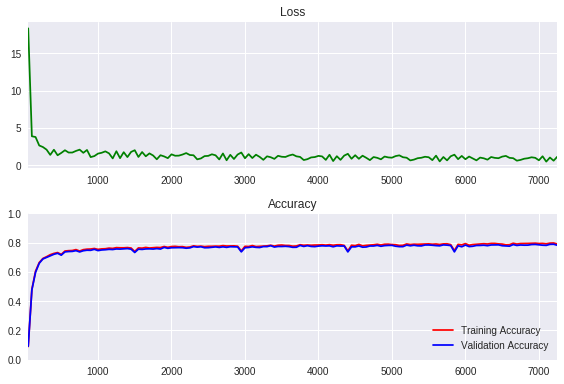

Validation accuracy at 0.7824000120162964
####################################
Running cross validation options four
####################################


Epoch  1/1: 100%|██████████| 1425/1425 [00:09<00:00, 157.46batches/s]


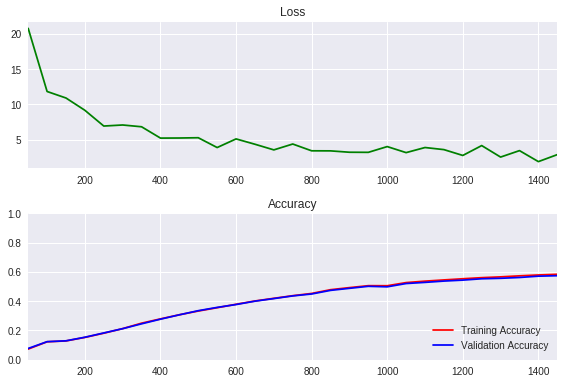

Validation accuracy at 0.5774666666984558


Epoch  1/1: 100%|██████████| 1425/1425 [00:09<00:00, 153.77batches/s]


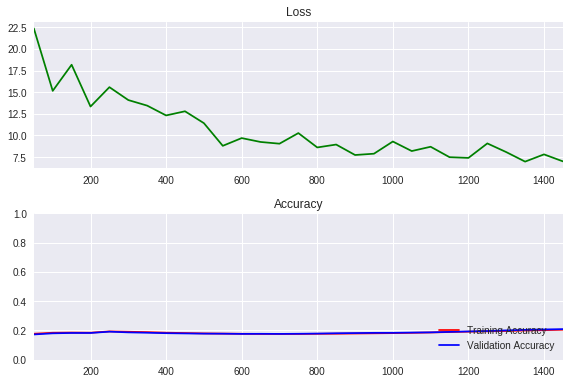

Validation accuracy at 0.21040000021457672


Epoch  1/1: 100%|██████████| 1425/1425 [00:09<00:00, 156.89batches/s]


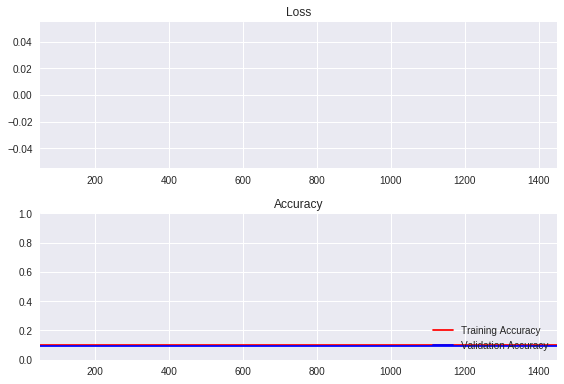

Validation accuracy at 0.09359999746084213


Epoch  1/1: 100%|██████████| 1425/1425 [00:09<00:00, 157.55batches/s]


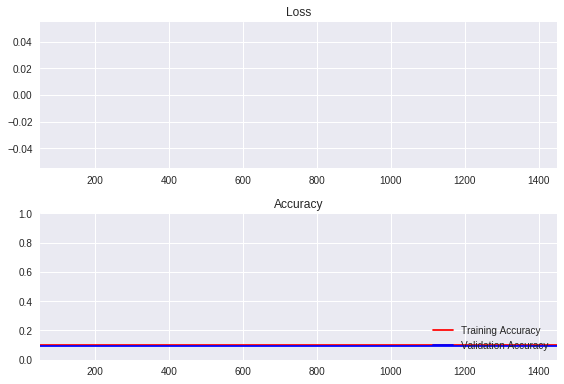

Validation accuracy at 0.09359999746084213


Epoch  1/1: 100%|██████████| 713/713 [00:04<00:00, 143.21batches/s]


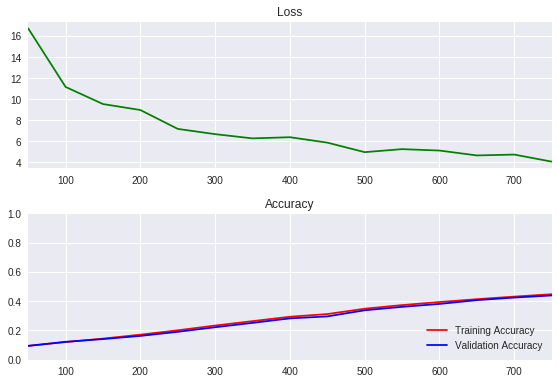

Validation accuracy at 0.44359999895095825


Epoch  1/1: 100%|██████████| 713/713 [00:04<00:00, 143.52batches/s]


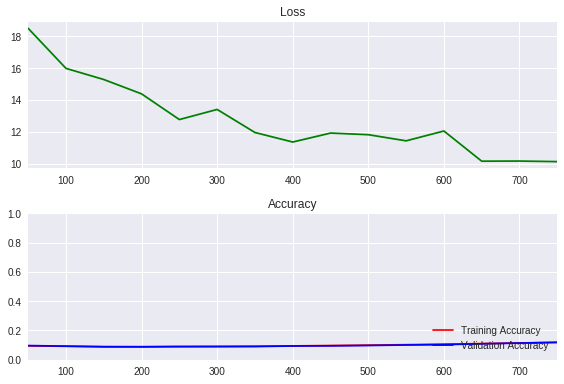

Validation accuracy at 0.11973333358764648


Epoch  1/1: 100%|██████████| 713/713 [00:04<00:00, 144.55batches/s]


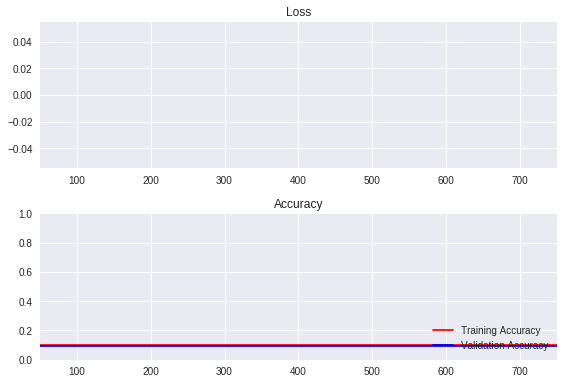

Validation accuracy at 0.09359999746084213


Epoch  1/1: 100%|██████████| 713/713 [00:04<00:00, 143.87batches/s]


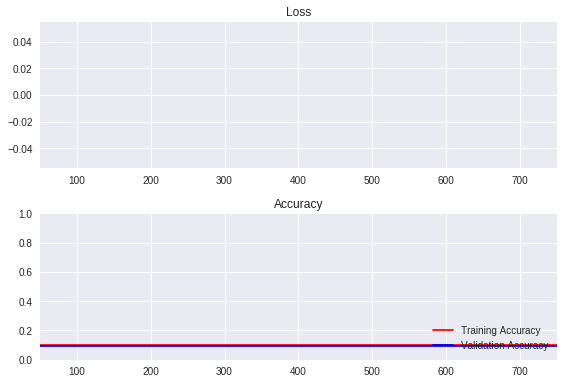

Validation accuracy at 0.09359999746084213


Epoch  1/1: 100%|██████████| 475/475 [00:03<00:00, 135.57batches/s]


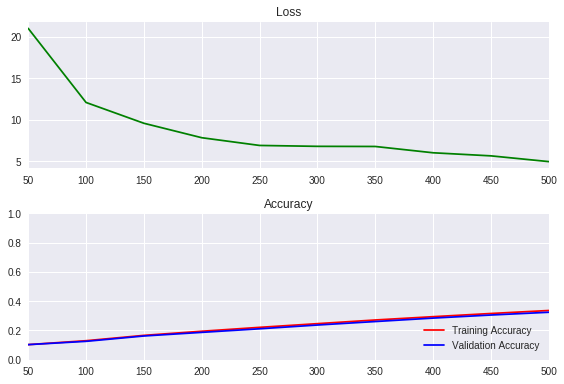

Validation accuracy at 0.3467999994754791


Epoch  1/1: 100%|██████████| 475/475 [00:03<00:00, 137.10batches/s]


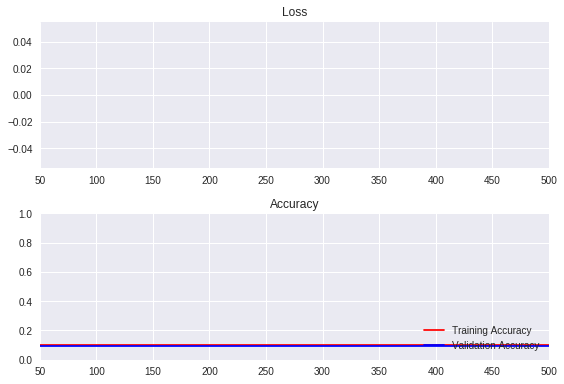

Validation accuracy at 0.09359999746084213


Epoch  1/1: 100%|██████████| 475/475 [00:03<00:00, 137.10batches/s]


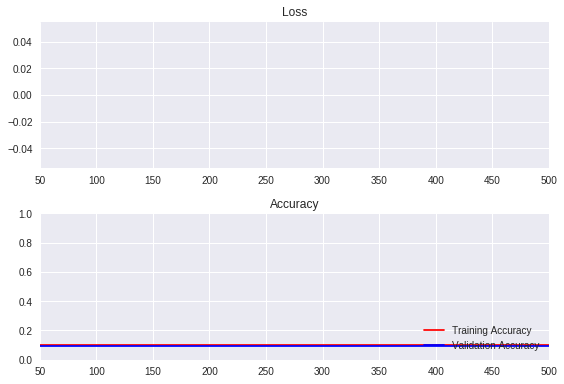

Validation accuracy at 0.09359999746084213


Epoch  1/1: 100%|██████████| 475/475 [00:03<00:00, 137.79batches/s]


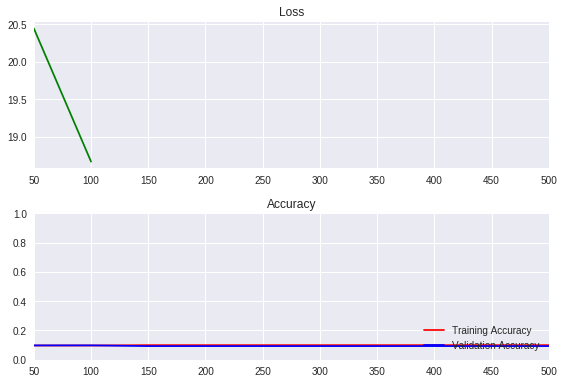

Validation accuracy at 0.09359999746084213


Epoch  1/1: 100%|██████████| 357/357 [00:02<00:00, 127.80batches/s]


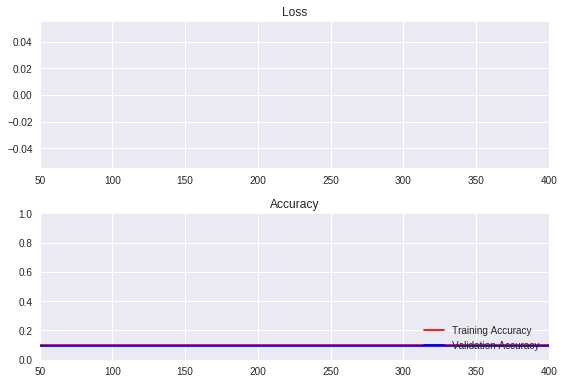

Validation accuracy at 0.09359999746084213


Epoch  1/1: 100%|██████████| 357/357 [00:02<00:00, 127.85batches/s]


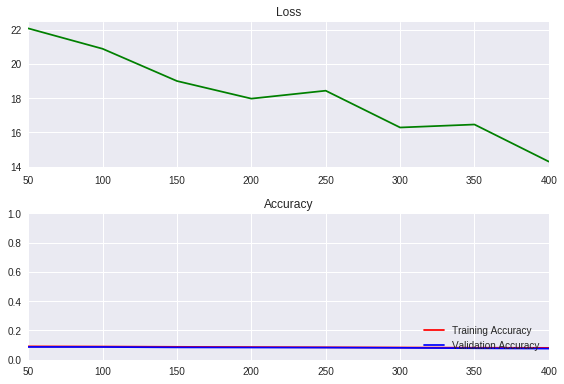

Validation accuracy at 0.07720000296831131


Epoch  1/1: 100%|██████████| 357/357 [00:02<00:00, 128.76batches/s]


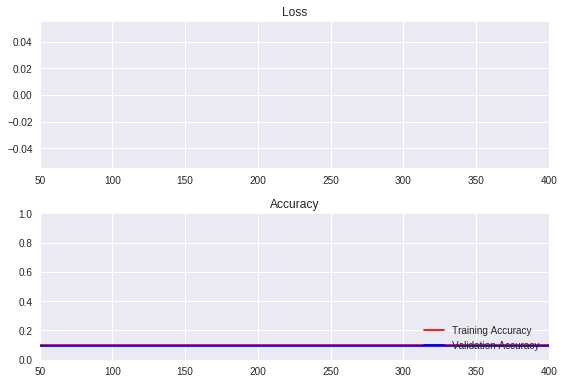

Validation accuracy at 0.09359999746084213


Epoch  1/1: 100%|██████████| 357/357 [00:02<00:00, 128.17batches/s]


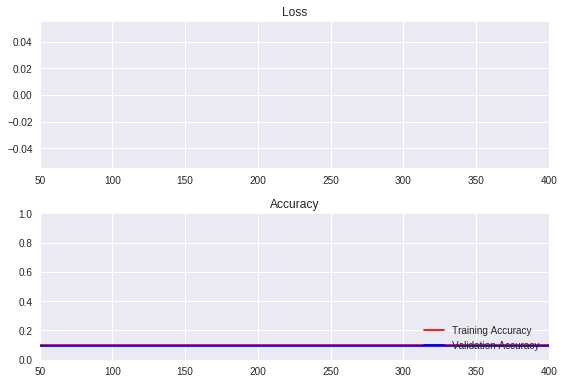

Validation accuracy at 0.09359999746084213


Epoch  2/2: 100%|██████████| 1425/1425 [00:08<00:00, 159.93batches/s]


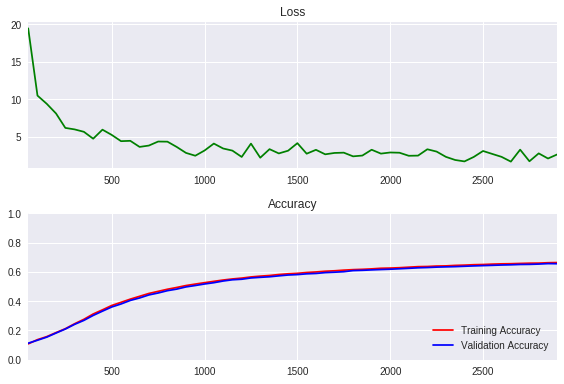

Validation accuracy at 0.658133327960968


Epoch  2/2: 100%|██████████| 1425/1425 [00:08<00:00, 159.11batches/s]


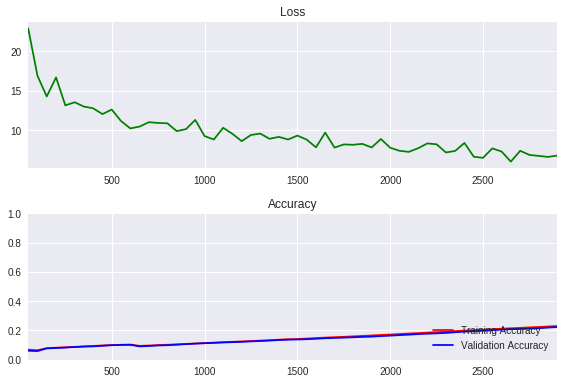

Validation accuracy at 0.2253333330154419


Epoch  2/2: 100%|██████████| 1425/1425 [00:08<00:00, 160.42batches/s]


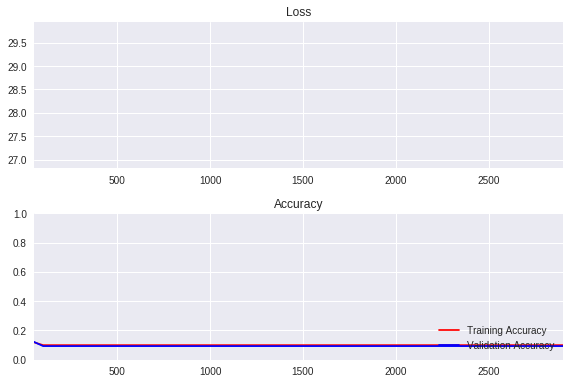

Validation accuracy at 0.09359999746084213


Epoch  2/2: 100%|██████████| 1425/1425 [00:08<00:00, 161.07batches/s]


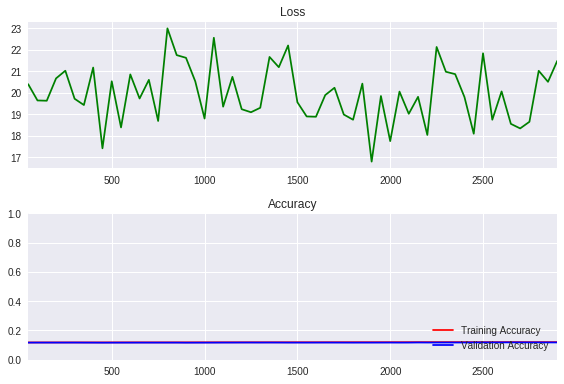

Validation accuracy at 0.11840000003576279


Epoch  2/2: 100%|██████████| 713/713 [00:04<00:00, 152.55batches/s]


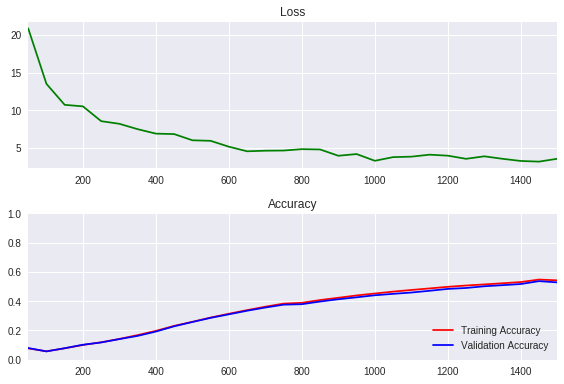

Validation accuracy at 0.5469333529472351


Epoch  2/2: 100%|██████████| 713/713 [00:04<00:00, 154.64batches/s]


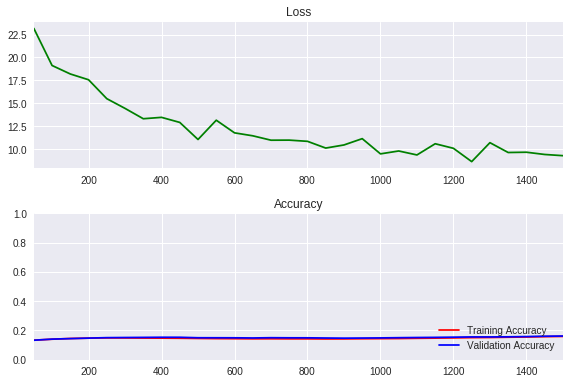

Validation accuracy at 0.1626666635274887


Epoch  2/2: 100%|██████████| 713/713 [00:04<00:00, 155.10batches/s]


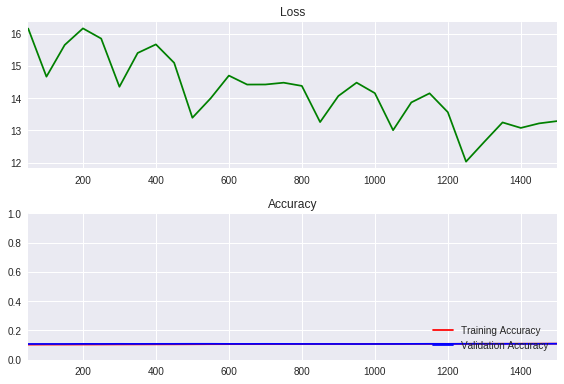

Validation accuracy at 0.1101333349943161


Epoch  2/2: 100%|██████████| 713/713 [00:04<00:00, 154.16batches/s]


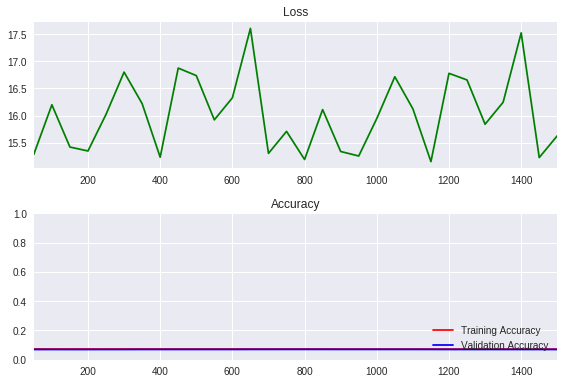

Validation accuracy at 0.07013333588838577


Epoch  2/2: 100%|██████████| 475/475 [00:03<00:00, 146.08batches/s]


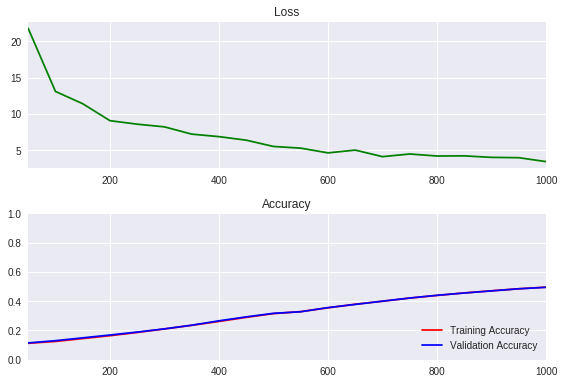

Validation accuracy at 0.5005333423614502


Epoch  2/2: 100%|██████████| 475/475 [00:03<00:00, 147.56batches/s]


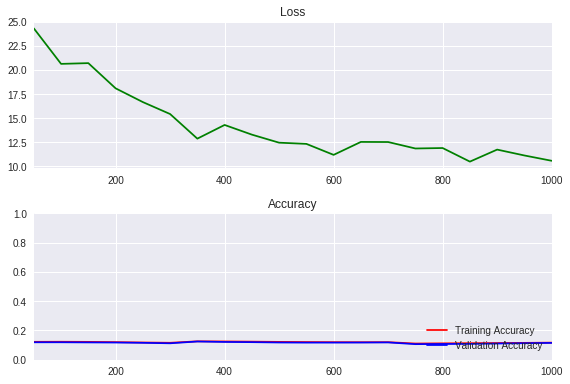

Validation accuracy at 0.11586666852235794


Epoch  2/2: 100%|██████████| 475/475 [00:03<00:00, 148.86batches/s]


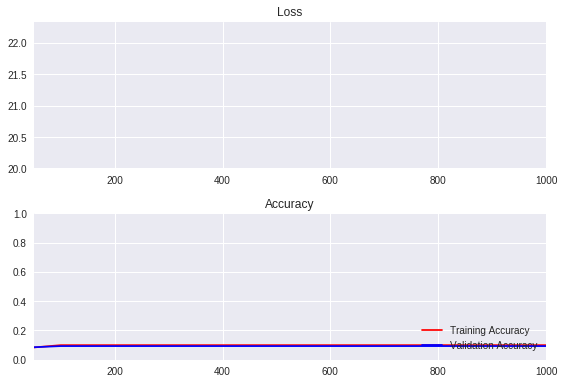

Validation accuracy at 0.09359999746084213


Epoch  2/2: 100%|██████████| 475/475 [00:03<00:00, 148.05batches/s]


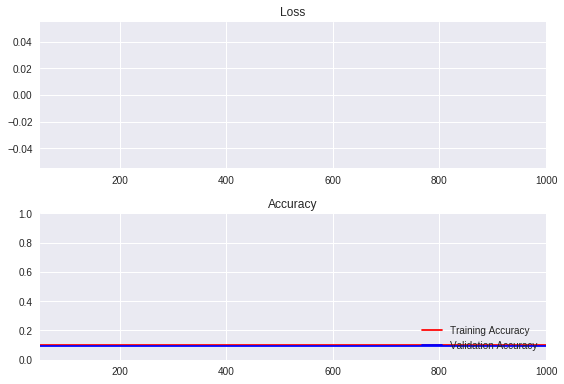

Validation accuracy at 0.09359999746084213


Epoch  2/2: 100%|██████████| 357/357 [00:02<00:00, 141.29batches/s]


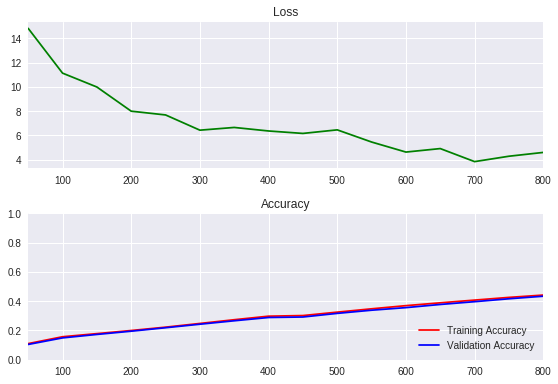

Validation accuracy at 0.43586665391921997


Epoch  2/2: 100%|██████████| 357/357 [00:02<00:00, 140.52batches/s]


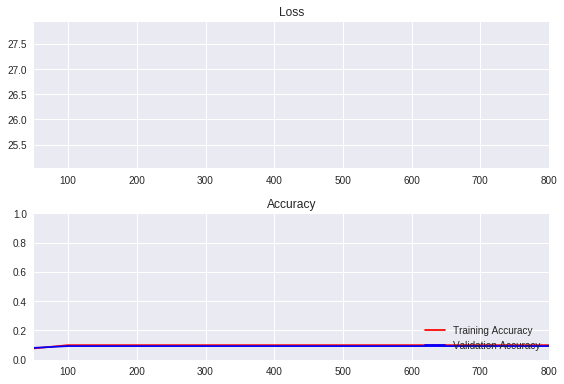

Validation accuracy at 0.09359999746084213


Epoch  2/2: 100%|██████████| 357/357 [00:02<00:00, 138.02batches/s]


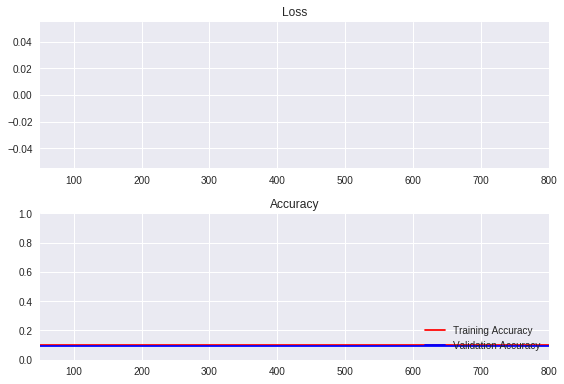

Validation accuracy at 0.09359999746084213


Epoch  2/2: 100%|██████████| 357/357 [00:02<00:00, 136.44batches/s]


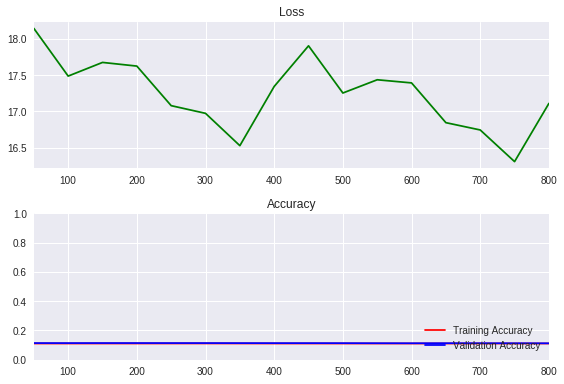

Validation accuracy at 0.11266666650772095


Epoch  3/3: 100%|██████████| 1425/1425 [00:08<00:00, 160.66batches/s]


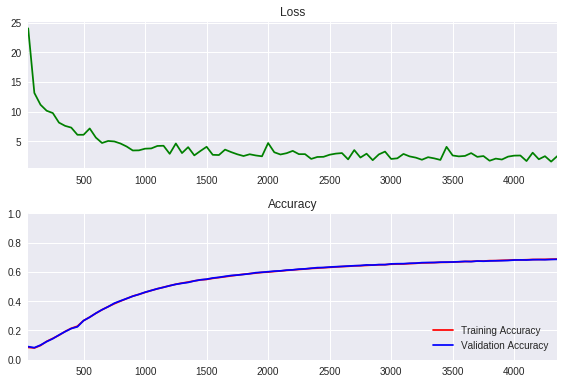

Validation accuracy at 0.68586665391922


Epoch  3/3: 100%|██████████| 1425/1425 [00:08<00:00, 160.64batches/s]


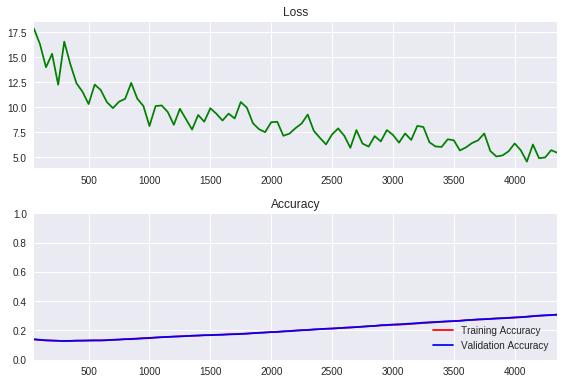

Validation accuracy at 0.3097333312034607


Epoch  3/3: 100%|██████████| 1425/1425 [00:08<00:00, 160.61batches/s]


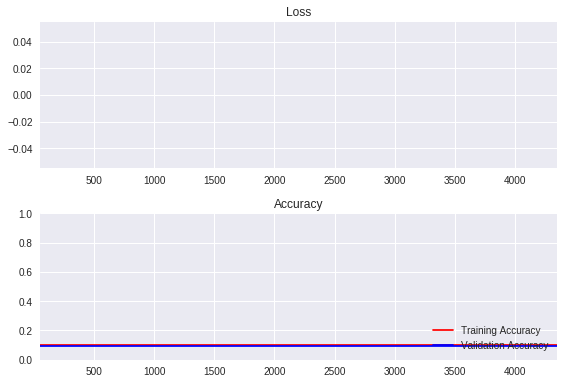

Validation accuracy at 0.09359999746084213


Epoch  3/3: 100%|██████████| 1425/1425 [00:08<00:00, 160.97batches/s]


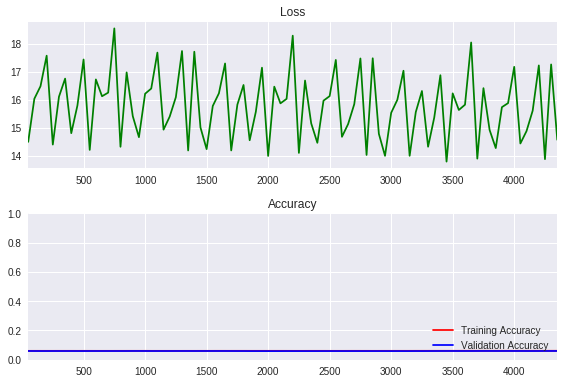

Validation accuracy at 0.06013333424925804


Epoch  3/3: 100%|██████████| 713/713 [00:04<00:00, 155.00batches/s]


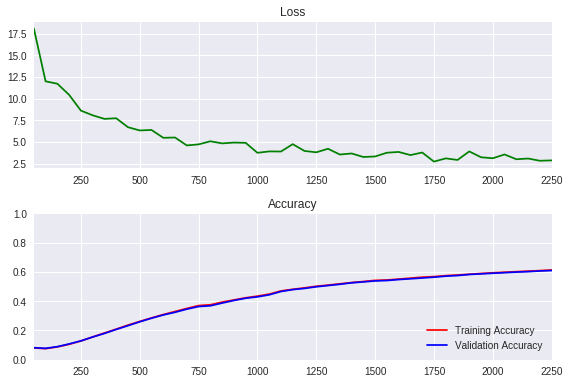

Validation accuracy at 0.6098666787147522


Epoch  3/3: 100%|██████████| 713/713 [00:04<00:00, 153.72batches/s]


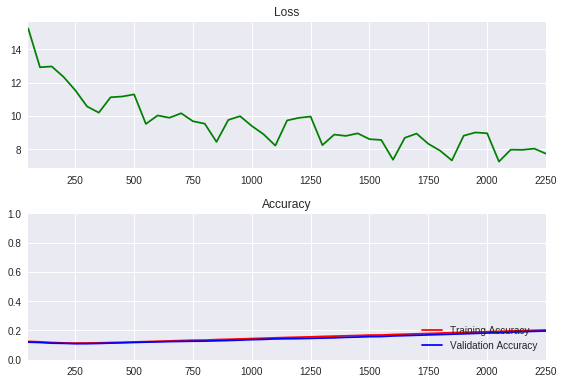

Validation accuracy at 0.19653333723545074


Epoch  3/3: 100%|██████████| 713/713 [00:04<00:00, 151.47batches/s]


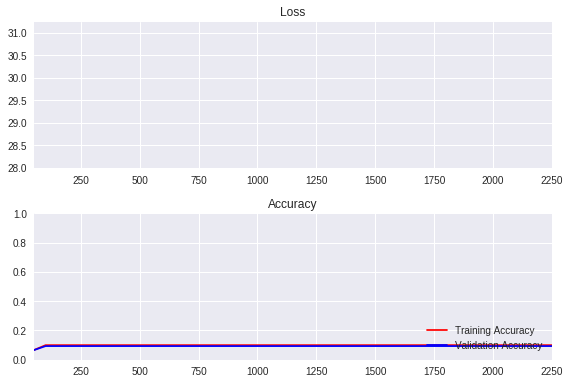

Validation accuracy at 0.09359999746084213


Epoch  3/3: 100%|██████████| 713/713 [00:04<00:00, 133.88batches/s]


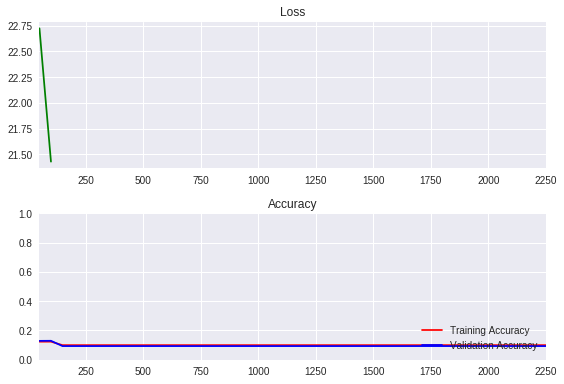

Validation accuracy at 0.09359999746084213


Epoch  3/3: 100%|██████████| 475/475 [00:03<00:00, 151.72batches/s]


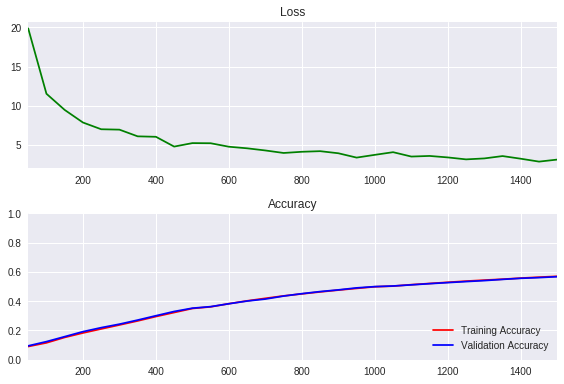

Validation accuracy at 0.5702666640281677


Epoch  3/3: 100%|██████████| 475/475 [00:03<00:00, 151.02batches/s]


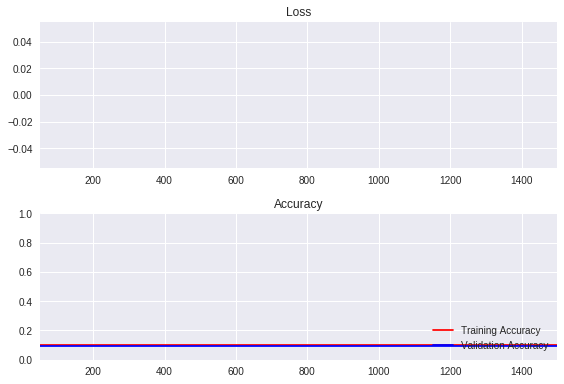

Validation accuracy at 0.09359999746084213


Epoch  3/3: 100%|██████████| 475/475 [00:03<00:00, 150.72batches/s]


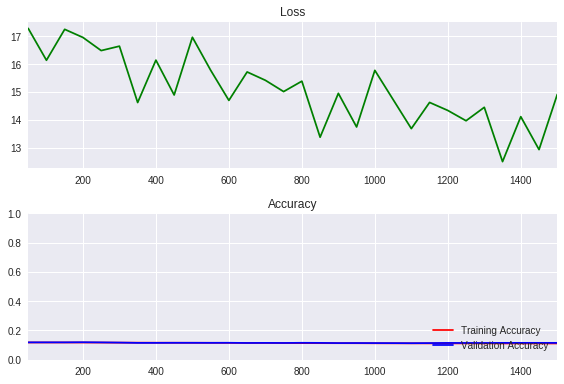

Validation accuracy at 0.11533333361148834


Epoch  3/3: 100%|██████████| 475/475 [00:03<00:00, 151.13batches/s]


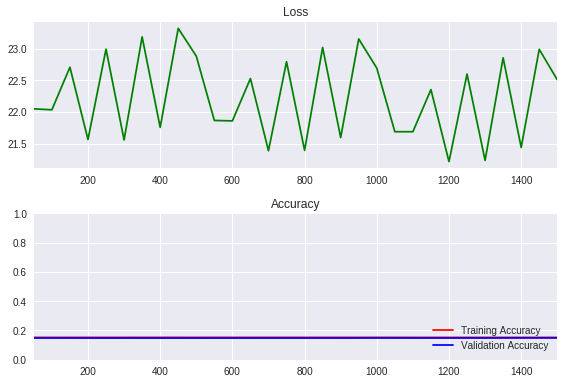

Validation accuracy at 0.14920000731945038


Epoch  3/3: 100%|██████████| 357/357 [00:02<00:00, 141.94batches/s]


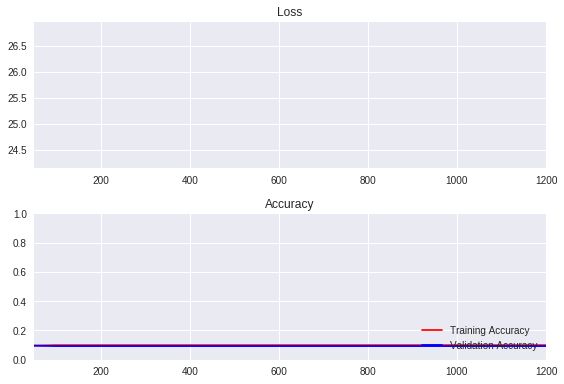

Validation accuracy at 0.09359999746084213


Epoch  3/3: 100%|██████████| 357/357 [00:02<00:00, 141.83batches/s]


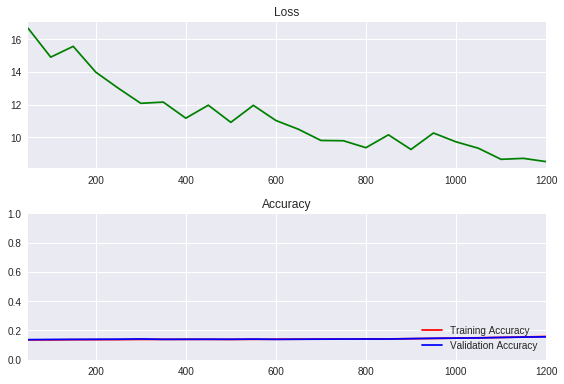

Validation accuracy at 0.15666666626930237


Epoch  3/3: 100%|██████████| 357/357 [00:02<00:00, 141.68batches/s]


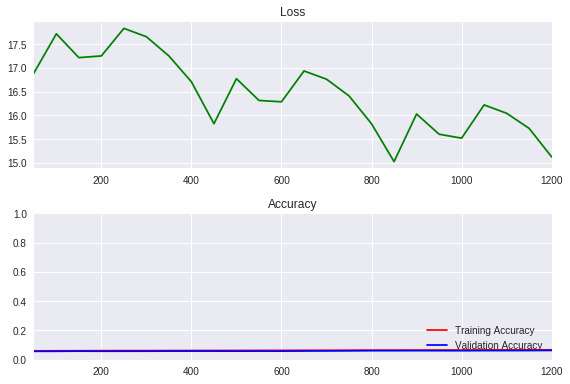

Validation accuracy at 0.06400000303983688


Epoch  3/3: 100%|██████████| 357/357 [00:02<00:00, 142.49batches/s]


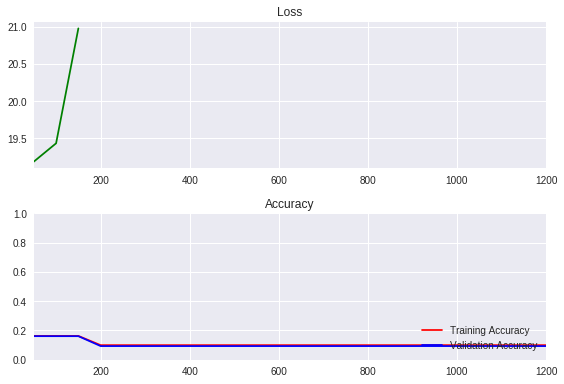

Validation accuracy at 0.09359999746084213


Epoch  4/4: 100%|██████████| 1425/1425 [00:08<00:00, 161.44batches/s]


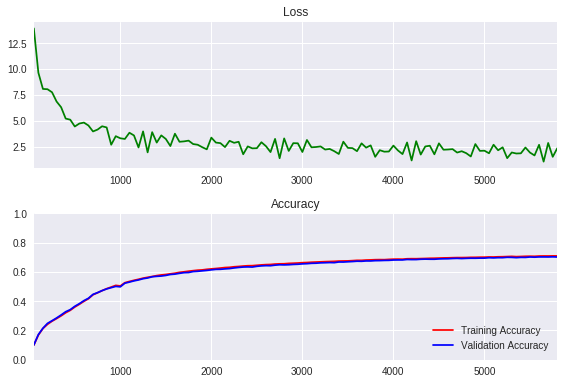

Validation accuracy at 0.7035999894142151


Epoch  4/4: 100%|██████████| 1425/1425 [00:08<00:00, 159.89batches/s]


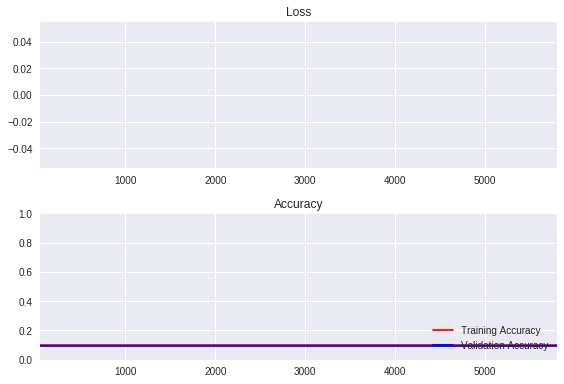

Validation accuracy at 0.09359999746084213


Epoch  4/4: 100%|██████████| 1425/1425 [00:08<00:00, 161.87batches/s]


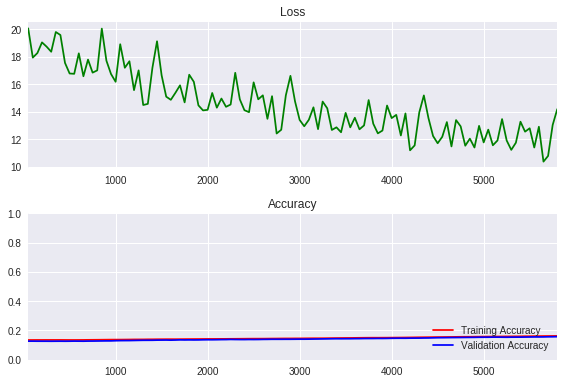

Validation accuracy at 0.15813332796096802


Epoch  4/4: 100%|██████████| 1425/1425 [00:08<00:00, 162.81batches/s]


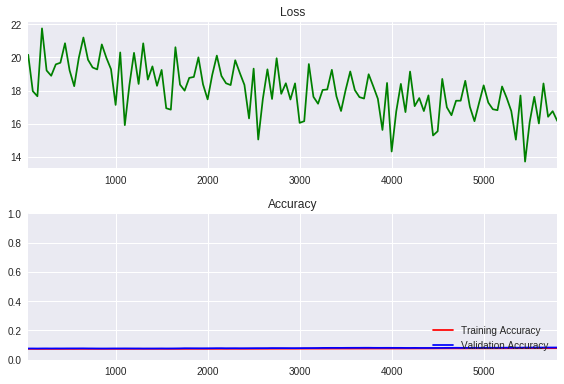

Validation accuracy at 0.0841333344578743


Epoch  4/4: 100%|██████████| 713/713 [00:04<00:00, 151.11batches/s]


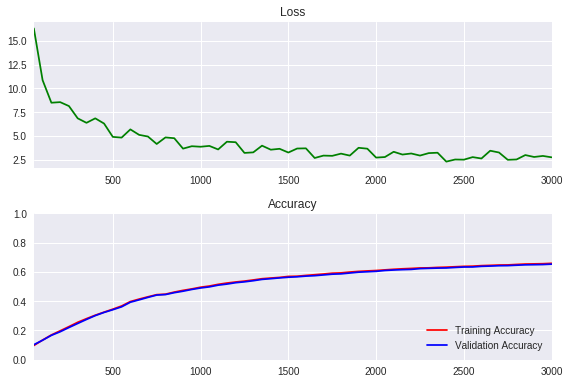

Validation accuracy at 0.6538666486740112


Epoch  4/4: 100%|██████████| 713/713 [00:04<00:00, 129.96batches/s]


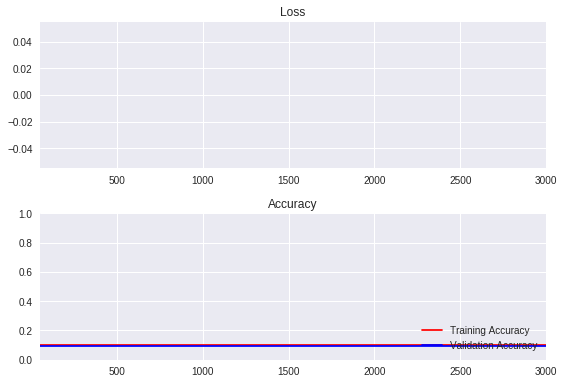

Validation accuracy at 0.09359999746084213


Epoch  4/4: 100%|██████████| 713/713 [00:04<00:00, 154.76batches/s]


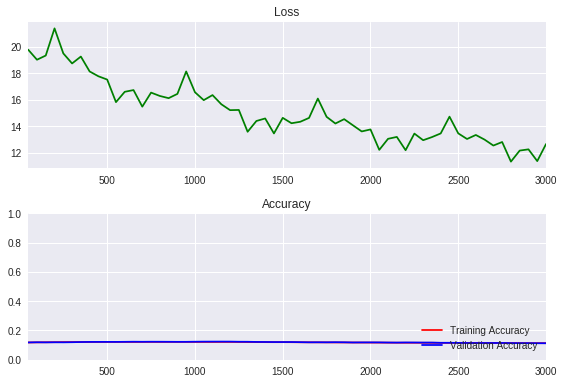

Validation accuracy at 0.1125333309173584


Epoch  4/4: 100%|██████████| 713/713 [00:04<00:00, 151.24batches/s]


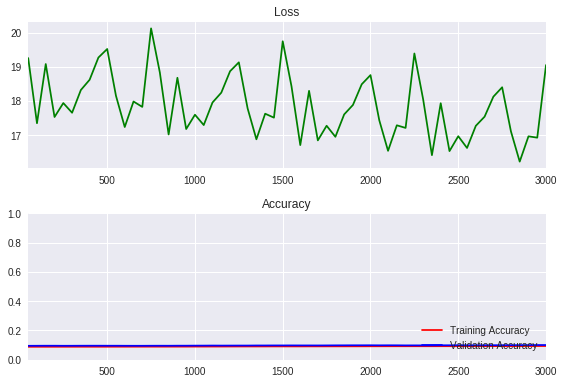

Validation accuracy at 0.10080000013113022


Epoch  4/4: 100%|██████████| 475/475 [00:03<00:00, 146.25batches/s]


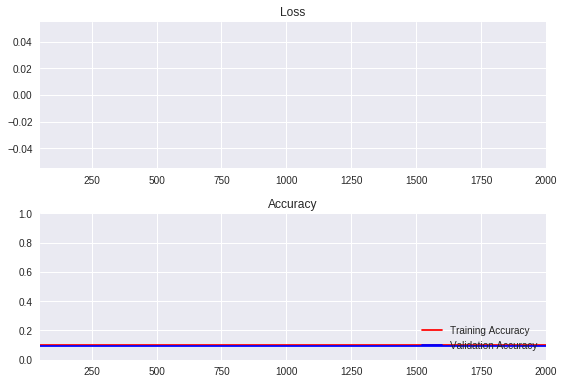

Validation accuracy at 0.09359999746084213


Epoch  4/4: 100%|██████████| 475/475 [00:03<00:00, 146.04batches/s]


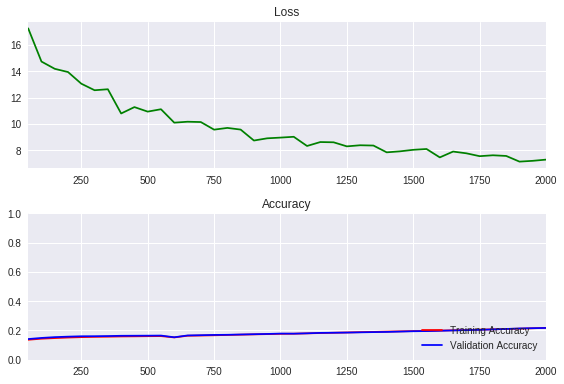

Validation accuracy at 0.2189333289861679


Epoch  4/4: 100%|██████████| 475/475 [00:03<00:00, 146.27batches/s]


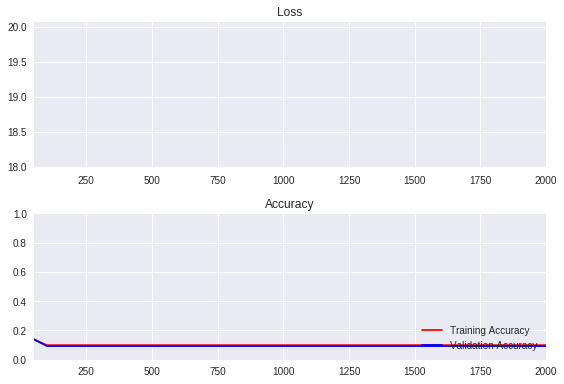

Validation accuracy at 0.09359999746084213


Epoch  4/4: 100%|██████████| 475/475 [00:03<00:00, 147.25batches/s]


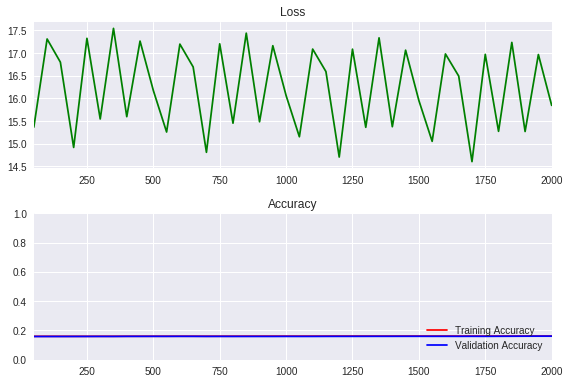

Validation accuracy at 0.1613333374261856


Epoch  4/4: 100%|██████████| 357/357 [00:02<00:00, 139.07batches/s]


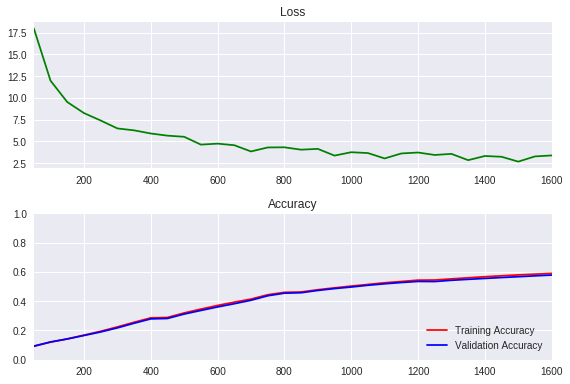

Validation accuracy at 0.578000009059906


Epoch  4/4: 100%|██████████| 357/357 [00:02<00:00, 139.84batches/s]


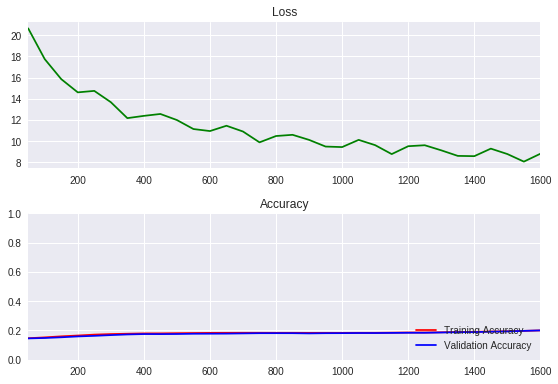

Validation accuracy at 0.20080000162124634


Epoch  4/4: 100%|██████████| 357/357 [00:02<00:00, 140.98batches/s]


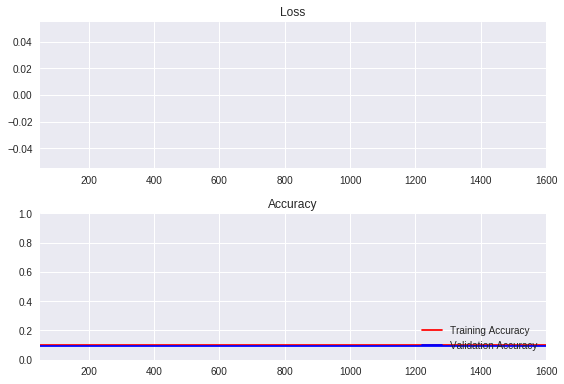

Validation accuracy at 0.09359999746084213


Epoch  4/4: 100%|██████████| 357/357 [00:02<00:00, 139.51batches/s]


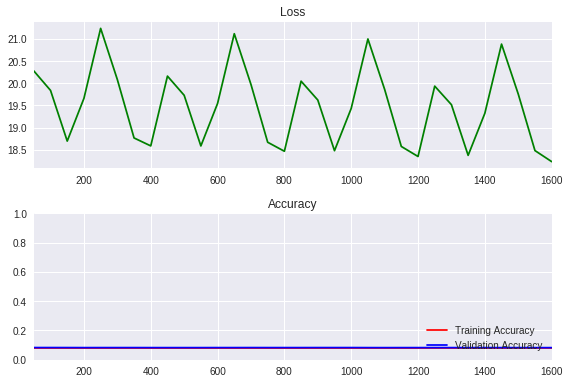

Validation accuracy at 0.08293333649635315


Epoch  5/5: 100%|██████████| 1425/1425 [00:08<00:00, 160.92batches/s]


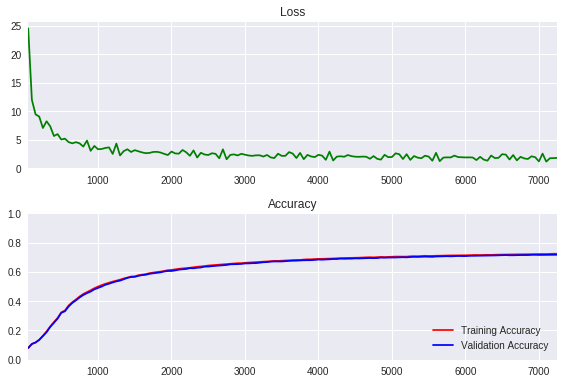

Validation accuracy at 0.7177333235740662


Epoch  5/5: 100%|██████████| 1425/1425 [00:08<00:00, 161.82batches/s]


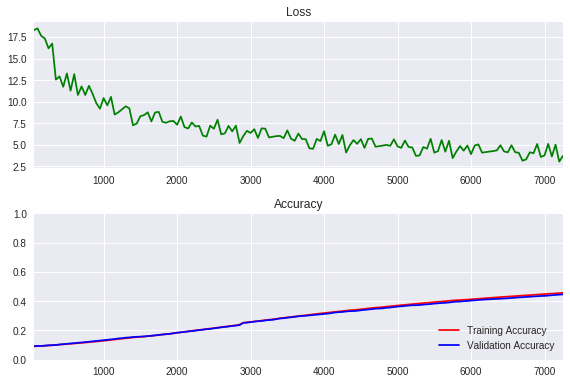

Validation accuracy at 0.4477333426475525


Epoch  5/5: 100%|██████████| 1425/1425 [00:08<00:00, 161.08batches/s]


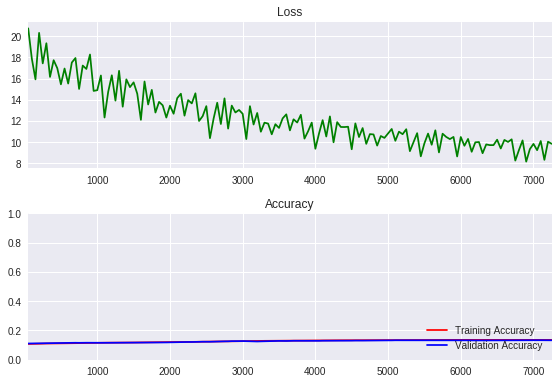

Validation accuracy at 0.13306666910648346


Epoch  5/5: 100%|██████████| 1425/1425 [00:08<00:00, 161.32batches/s]


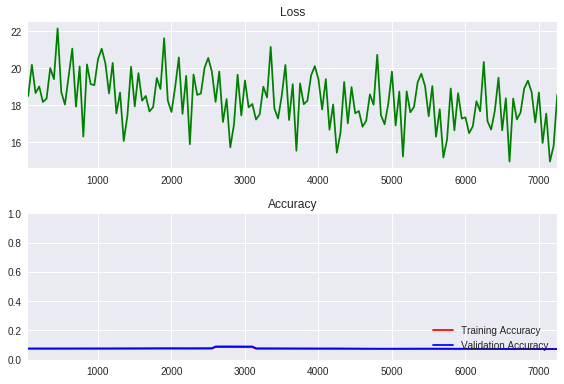

Validation accuracy at 0.07306666672229767


Epoch  5/5: 100%|██████████| 713/713 [00:04<00:00, 152.57batches/s]


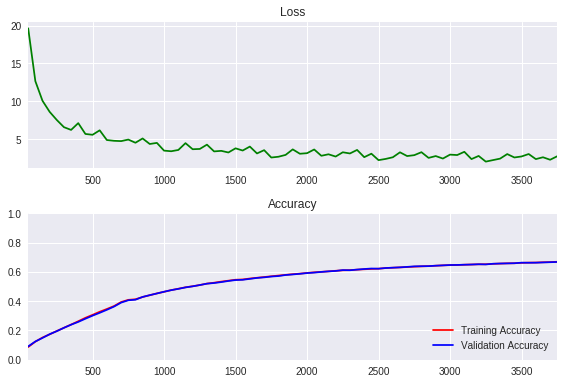

Validation accuracy at 0.6682666540145874


Epoch  5/5: 100%|██████████| 713/713 [00:04<00:00, 153.80batches/s]


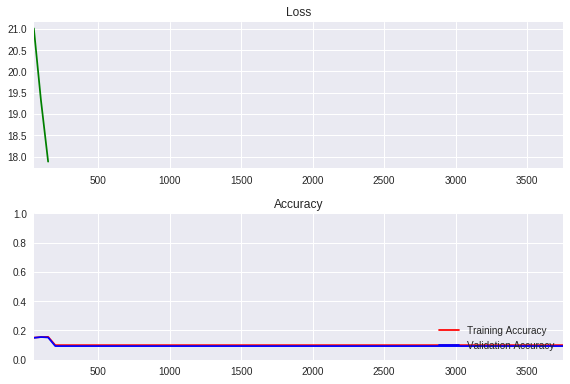

Validation accuracy at 0.09359999746084213


Epoch  5/5: 100%|██████████| 713/713 [00:04<00:00, 153.56batches/s]


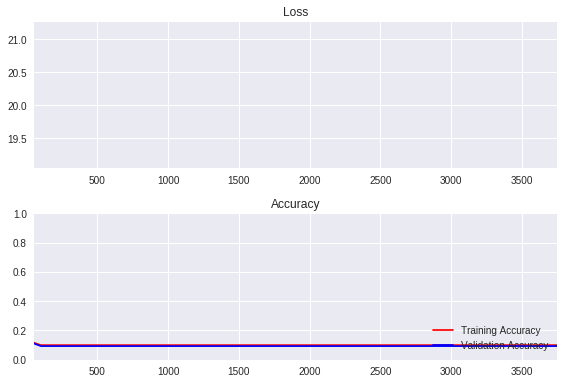

Validation accuracy at 0.09359999746084213


Epoch  5/5: 100%|██████████| 713/713 [00:04<00:00, 153.93batches/s]


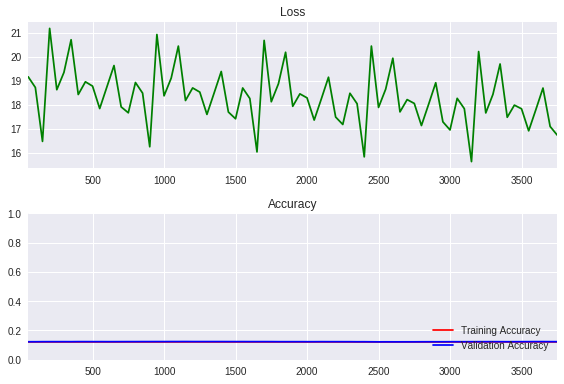

Validation accuracy at 0.12373333424329758


Epoch  5/5: 100%|██████████| 475/475 [00:03<00:00, 151.68batches/s]


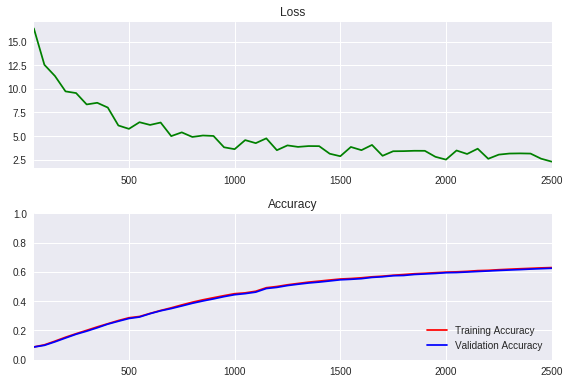

Validation accuracy at 0.6255999803543091


Epoch  5/5: 100%|██████████| 475/475 [00:03<00:00, 148.48batches/s]


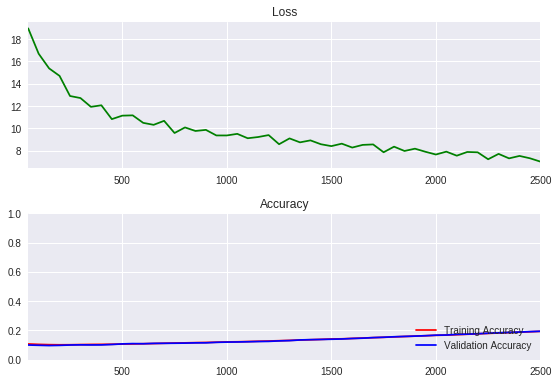

Validation accuracy at 0.1961333304643631


Epoch  5/5: 100%|██████████| 475/475 [00:03<00:00, 149.53batches/s]


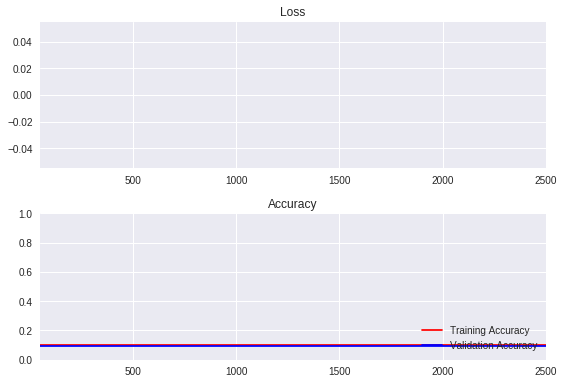

Validation accuracy at 0.09359999746084213


Epoch  5/5: 100%|██████████| 475/475 [00:03<00:00, 149.43batches/s]


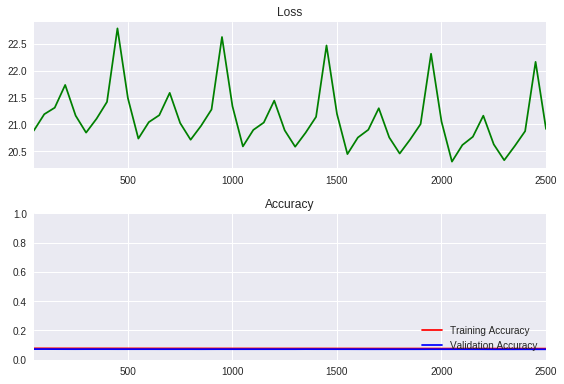

Validation accuracy at 0.07173333317041397


Epoch  5/5: 100%|██████████| 357/357 [00:02<00:00, 137.84batches/s]


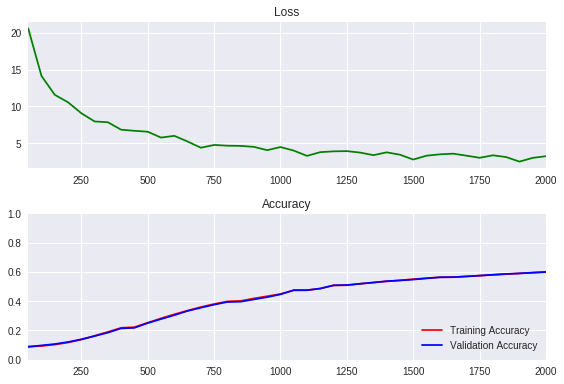

Validation accuracy at 0.6001333594322205


Epoch  5/5: 100%|██████████| 357/357 [00:02<00:00, 138.31batches/s]


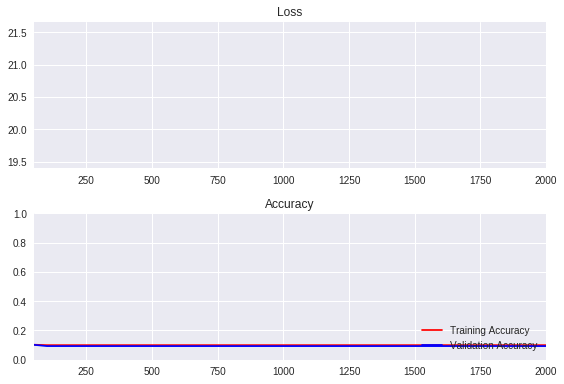

Validation accuracy at 0.09359999746084213


Epoch  5/5: 100%|██████████| 357/357 [00:02<00:00, 137.94batches/s]


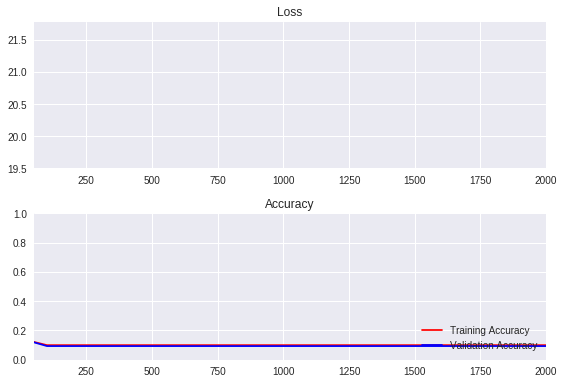

Validation accuracy at 0.09359999746084213


Epoch  5/5: 100%|██████████| 357/357 [00:02<00:00, 138.38batches/s]


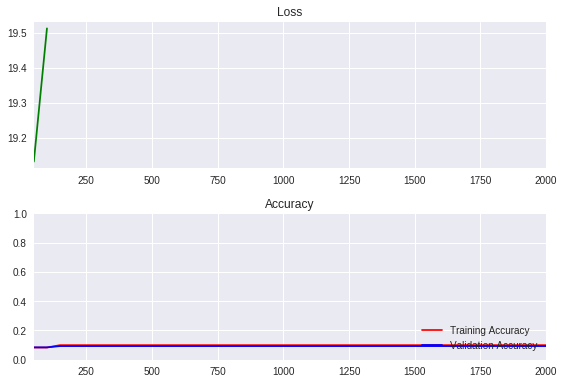

Validation accuracy at 0.09359999746084213



best learning rate: 0.2       
best batch size: 100       
best number of epochs: 5         
best cross validation accuracy: 0.7824000120162964


In [26]:
# TODO: Find the best parameters for each configuration

def corss_validation_loop(epochs, batch_size, learning_rate):
    ### DON'T MODIFY ANYTHING BELOW ###
    # Gradient Descent
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    
    
    # The accuracy measured against the validation set
    validation_accuracy = 0.0
    
    # Measurements use for graphing loss and accuracy
    log_batch_step = 50
    batches = []
    loss_batch = []
    train_acc_batch = []
    valid_acc_batch = []
    
    with tf.Session() as session:
        session.run(init)
        batch_count = int(math.ceil(len(train_features)/batch_size))
        
        for epoch_i in range(epochs):
            # Progress bar
            batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
            
            # The training cycle
            for batch_i in batches_pbar:
                # Get a batch of training features and labels
                batch_start = batch_i*batch_size
                batch_features = train_features[batch_start:batch_start + batch_size]
                batch_labels = train_labels[batch_start:batch_start + batch_size]
                
                # Run optimizer and get loss
                _, l = session.run(
                    [optimizer, loss],
                    feed_dict={features: batch_features, labels: batch_labels})
                
                # Log every 50 batches
                if not batch_i % log_batch_step:
                    # Calculate Training and Validation accuracy
                    training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                    validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
                    
                    # Log batches
                    previous_batch = batches[-1] if batches else 0
                    batches.append(log_batch_step + previous_batch)
                    loss_batch.append(l)
                    train_acc_batch.append(training_accuracy)
                    valid_acc_batch.append(validation_accuracy)
                
            # Check accuracy against Validation data
            validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
                
    loss_plot = plt.subplot(211)
    loss_plot.set_title('Loss')
    loss_plot.plot(batches, loss_batch, 'g')
    loss_plot.set_xlim([batches[0], batches[-1]])
    acc_plot = plt.subplot(212)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
    acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
    acc_plot.set_ylim([0, 1.0])
    acc_plot.set_xlim([batches[0], batches[-1]])
    acc_plot.legend(loc=4)
    plt.tight_layout()
    plt.show()
    
    print('Validation accuracy at {}'.format(validation_accuracy))
    return validation_accuracy
    
# cross validation
best_valiation_accuracy = 0.0
best_batch_size = 0
best_learning_rate = 0.0
best_num_epochs = 0

# option one
print('####################################')
print('Running cross validation options one')
print('####################################')
epochs_list = [1]
batch_size_list = [2000, 1000, 500, 300, 50]
learning_rate_list = [0.1]

for epochs in epochs_list:
    for batch_size in batch_size_list:
        for learning_rate in learning_rate_list:
            current_cv_accuracy = corss_validation_loop(epochs, batch_size, learning_rate)
            if current_cv_accuracy > best_valiation_accuracy:
                best_valiation_accuracy = current_cv_accuracy
                best_batch_size = batch_size
                best_learning_rate = learning_rate
                best_num_epochs = epochs

# option two
print('####################################')
print('Running cross validation options two')
print('####################################')
epochs_list = [1]
batch_size_list = [100]
learning_rate_list = [0.8, 0.5, 0.1, 0.05, 0.01]

for epochs in epochs_list:
    for batch_size in batch_size_list:
        for learning_rate in learning_rate_list:
            current_cv_accuracy = corss_validation_loop(epochs, batch_size, learning_rate)
            if current_cv_accuracy > best_valiation_accuracy:
                best_valiation_accuracy = current_cv_accuracy
                best_batch_size = batch_size
                best_learning_rate = learning_rate
                best_num_epochs = epochs
            
            
# option three
print('####################################')
print('Running cross validation options three')
print('####################################')
epochs_list = [1, 2, 3, 4, 5]
batch_size_list = [100]
learning_rate_list = [0.2]

for epochs in epochs_list:
    for batch_size in batch_size_list:
        for learning_rate in learning_rate_list:
            current_cv_accuracy = corss_validation_loop(epochs, batch_size, learning_rate)
            if current_cv_accuracy > best_valiation_accuracy:
                best_valiation_accuracy = current_cv_accuracy
                best_batch_size = batch_size
                best_learning_rate = learning_rate
                best_num_epochs = epochs
                
# option four
print('####################################')
print('Running cross validation options four')
print('####################################')
epochs_list = [1, 2, 3, 4, 5]
batch_size_list = [100,200,300,400]
learning_rate_list = [0.01,0.001,0.0001,0.00001]

for epochs in epochs_list:
    for batch_size in batch_size_list:
        for learning_rate in learning_rate_list:
            current_cv_accuracy = corss_validation_loop(epochs, batch_size, learning_rate)
            if current_cv_accuracy > best_valiation_accuracy:
                best_valiation_accuracy = current_cv_accuracy
                best_batch_size = batch_size
                best_learning_rate = learning_rate
                best_num_epochs = epochs
                
print('\n\n')
print('='*50)
print('best learning rate: {:<10}'.format(best_learning_rate))
print('best batch size: {:<10}'.format(best_batch_size))
print('best number of epochs: {:<10}'.format(best_num_epochs))
print('best cross validation accuracy: {:<10}'.format(best_valiation_accuracy))
print('='*50)

In [29]:
# TODO: Set the epochs, batch_size, and learning_rate with the best parameters from problem 3
epochs = best_num_epochs
batch_size = best_batch_size
learning_rate = best_learning_rate



### DON'T MODIFY ANYTHING BELOW ###
# The accuracy measured against the test set
test_accuracy = 0.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss) 

with tf.Session() as session:
    
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer
            _ = session.run(optimizer, feed_dict={features: batch_features, labels: batch_labels})

        # Check accuracy against Test data
        test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)


assert test_accuracy >= 0.78, 'Test accuracy at {}, should be equal to or greater than 0.80'.format(test_accuracy)
print('Nice Job! Test Accuracy is {}'.format(test_accuracy))

Epoch  5/5: 100%|██████████| 1425/1425 [00:02<00:00, 503.05batches/s]

Nice Job! Test Accuracy is 0.8593999743461609
